In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#!pip install seaborn

In [3]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.

import tensorflow as tf

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)

seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

## Load data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('IDRiD/DiseaseGrading/Groundtruths/TestingLabels.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["Image name"].apply(lambda x: x + ".jpg")
train['diagnosis'] = train['diagnosis'].astype('str')
display(test.head())


Number of train samples:  3662
Number of test samples:  103


,Image name,Retinopathy grade,Risk of macular edema,id_code
0,IDRiD_001,4,0,IDRiD_001.jpg
1,IDRiD_002,4,1,IDRiD_002.jpg
2,IDRiD_003,4,0,IDRiD_003.jpg
3,IDRiD_004,4,0,IDRiD_004.jpg
4,IDRiD_005,4,1,IDRiD_005.jpg


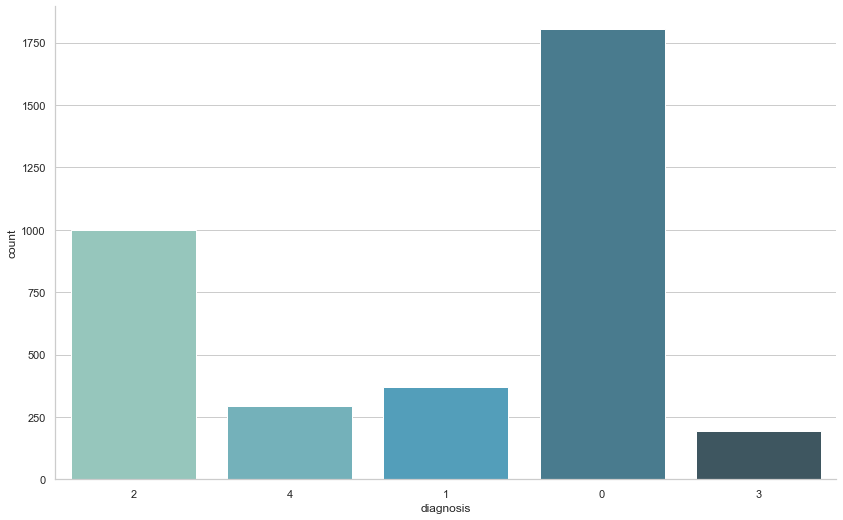

In [5]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

000c1434d8d7.png
001639a390f0.png
0024cdab0c1e.png
002c21358ce6.png
005b95c28852.png
0083ee8054ee.png
0097f532ac9f.png
00a8624548a9.png
00b74780d31d.png
00cb6555d108.png
00cc2b75cddd.png
00e4ddff966a.png
00f6c1be5a33.png
0104b032c141.png
0124dffecf29.png


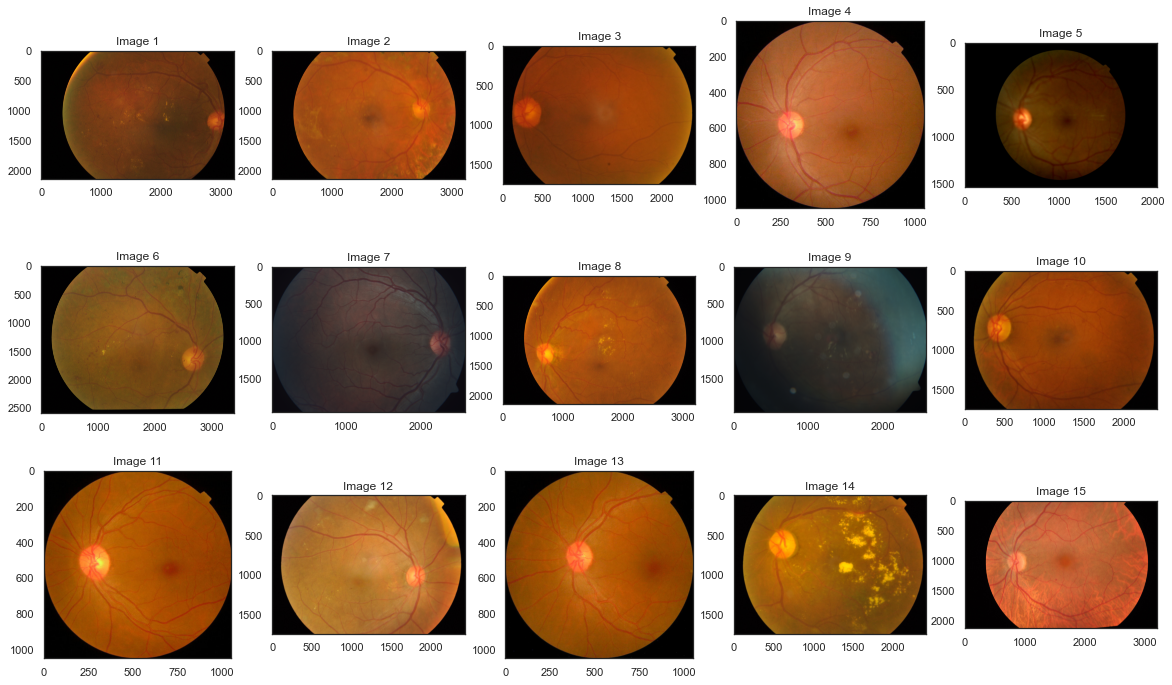

In [6]:
import cv2
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    print(img_name)
    img = cv2.imread("train_images/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

# Model parameters

In [7]:
# Model parameters
BATCH_SIZE = 16
EPOCHS = 50
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512#1024#3216/2
WIDTH = 512#1024#2136/2
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

## Train test split

In [8]:
def crop_image_from_gray(image, tolerance=8):
    if image.ndim == 2:
        mask = image > tolerance
        return image[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif image.ndim == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = gray_image > tolerance
        
        check_shape = image[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return image # return original image
        else:
            img1=image[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=image[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=image[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            image = np.stack([img1,img2,img3],axis=-1)
        return image

In [9]:
def preprocess_image(image, sigmaX=12):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

# Data generator

In [10]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True, 
                                 fill_mode='nearest')

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')


valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

#test_datagen = ImageDataGenerator(rescale=1./255)
                                 #reprocessing_function=preprocess_image)
'''
test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)
'''

Found 2919 validated image filenames belonging to 5 classes.
Found 729 validated image filenames belonging to 5 classes.


'\ntest_generator = test_datagen.flow_from_dataframe(  \n        dataframe=test,\n        directory = "test_images/",\n        x_col="id_code",\n        target_size=(HEIGHT, WIDTH),\n        batch_size=1,\n        shuffle=False,\n        class_mode=None)\n'

In [11]:
test

,Image name,Retinopathy grade,Risk of macular edema,id_code
0,IDRiD_001,4,0,IDRiD_001.jpg
1,IDRiD_002,4,1,IDRiD_002.jpg
2,IDRiD_003,4,0,IDRiD_003.jpg
3,IDRiD_004,4,0,IDRiD_004.jpg
4,IDRiD_005,4,1,IDRiD_005.jpg
...,...,...,...,...
98,IDRiD_099,0,0,IDRiD_099.jpg
99,IDRiD_100,2,1,IDRiD_100.jpg
100,IDRiD_101,1,0,IDRiD_101.jpg
101,IDRiD_102,2,2,IDRiD_102.jpg


In [12]:
# Convert "Retinopathy grade" column values to strings
test["Retinopathy grade"] = test["Retinopathy grade"].astype(str)
test

,Image name,Retinopathy grade,Risk of macular edema,id_code
0,IDRiD_001,4,0,IDRiD_001.jpg
1,IDRiD_002,4,1,IDRiD_002.jpg
2,IDRiD_003,4,0,IDRiD_003.jpg
3,IDRiD_004,4,0,IDRiD_004.jpg
4,IDRiD_005,4,1,IDRiD_005.jpg
...,...,...,...,...
98,IDRiD_099,0,0,IDRiD_099.jpg
99,IDRiD_100,2,1,IDRiD_100.jpg
100,IDRiD_101,1,0,IDRiD_101.jpg
101,IDRiD_102,2,2,IDRiD_102.jpg


In [13]:

# Create the test generator test = pd.read_csv('IDRiD/DiseaseGrading/Groundtruths/TestingLabels.csv')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="IDRiD/DiseaseGrading/OriginalImages/TestingSet/",
    x_col="id_code",
    y_col="Retinopathy grade",
    target_size=(HEIGHT, WIDTH),
    batch_size=1,
    shuffle=False,
    class_mode="categorical"
)


Found 103 validated image filenames belonging to 5 classes.


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy


In [15]:
#!pip install resnet

# Model

In [16]:
def create_model(input_shape, n_out):
    
    #input_tensor = Input(shape=input_shape)
    
    base_model = ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out, activation='softmax', name='final_output'))
    '''
    #base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    print(base_model)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    '''
    '''
    mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet',input_shape=input_shape, include_top=False)
    #mobile.summary()
    x = mobile.layers[-6].output

    # Create a new dense layer for predictions
    # 2 corresponds to the number of classes
    x = Dropout(0.25)(x)
    predictions = Dense(n_out, activation='softmax',name='final_output')(x)

    # inputs=mobile.input selects the input layer, outputs=predictions refers to the
    # dense layer we created above.

    model = Model(inputs=mobile.input, outputs=predictions)
    '''
    return model




In [17]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense

def create_modelfun(input_shape, n_out):
    # Define input tensor
    input_tensor = Input(shape=input_shape)
    
    # Load pre-trained ResNet50 model with imagenet weights
    base_model = ResNet50(weights='imagenet', include_top=False)
    
    # Freeze all layers in the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Define output tensor
    x = base_model(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(n_out, activation='softmax', name='final_output')(x)
    
    # Define the full model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    return model


In [18]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow import keras
import tensorflow as tf

In [19]:
# Define the AlexNet model [This is given]
#1. Model Definition
class AlexNet(Sequential):
   def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(Flatten())
    
    self.add(Dense(num_classes, activation= 'sigmoid'))


In [21]:
'''
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)


for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:-5]:
    layer.trainable = True

for layer in model.layers[:-23]:
    layer.trainable = False

optimizer = tf.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

early_stopper = EarlyStopping(monitor="val_categorical_accuracy", 
                      mode="max", 
                      patience=7)

                              
callbacks_list = [reduce_lr, early_stopper]


metric_list = ["accuracy"]
optimizer = tf.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()
'''
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)
#model = AlexNet((HEIGHT, WIDTH, CANAL), N_CLASSES)
print(model.summary())

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:-5]:
    layer.trainable = True

metric_list = ["accuracy"]
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=metric_list)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0

In [55]:
model_fun = create_modelfun(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

The following Variables were used a Lambda layer's call (tf.nn.convolution_53), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_53), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_53), but
are not present in its tracked objects:
  <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/be

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [22]:
N_CLASSES

5

In [23]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train['diagnosis']),y=train['diagnosis'])
cls_wt_dict = dict(enumerate(class_weights))

In [24]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train['diagnosis']),y=train['diagnosis'])
cls_wt_dict = dict(enumerate(class_weights))


history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history
'''
history_warmup = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, class_weight=cls_wt_dict,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=WARMUP_EPOCHS, verbose=1)
'''

Epoch 1/5
182/182 [==============================] - 2121s 12s/step - loss: 1.2633 - accuracy: 0.5126 - val_loss: 1.6094 - val_accuracy: 0.3250
Epoch 2/5
182/182 [==============================] - 2131s 12s/step - loss: 1.0819 - accuracy: 0.5729 - val_loss: 1.6094 - val_accuracy: 0.4639
Epoch 3/5
182/182 [==============================] - 2116s 12s/step - loss: 1.0549 - accuracy: 0.5680 - val_loss: 1.8482 - val_accuracy: 0.3000
Epoch 4/5
182/182 [==============================] - 2117s 12s/step - loss: 1.0330 - accuracy: 0.6107 - val_loss: 1.9784 - val_accuracy: 0.3389
Epoch 5/5
182/182 [==============================] - 2119s 12s/step - loss: 1.0344 - accuracy: 0.6094 - val_loss: 1.5659 - val_accuracy: 0.4347


'\nhistory_warmup = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, class_weight=cls_wt_dict,\n                    validation_data=valid_generator,\n                    validation_steps=STEP_SIZE_VALID,\n                    epochs=WARMUP_EPOCHS, verbose=1)\n'

In [25]:
#model = tf.keras.models.load_model("ecarebetics_model.h5")

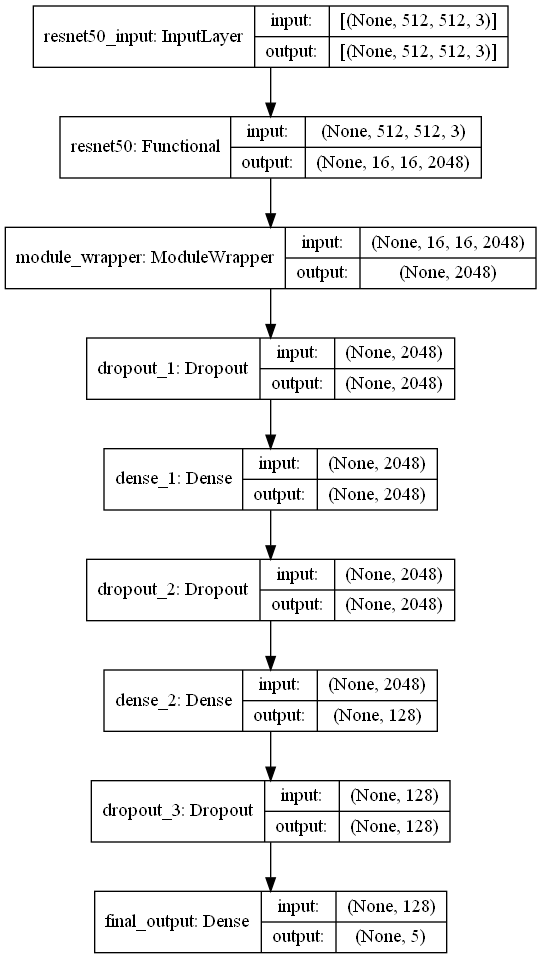

In [26]:
tf.keras.utils.plot_model(model, to_file='Model.png', show_shapes=True)

In [27]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
# Define optimizer
#from keras.optimizers import Adam
#optimizer = Adam(lr=LEARNING_RATE)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0

In [28]:
next(train_generator)

(array([[[[3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          ...,
          [2.95519866e-02, 6.02257391e-03, 6.02257391e-03],
          [2.64856014e-02, 2.95618922e-03, 2.95618922e-03],
          [2.36396082e-02, 1.10195178e-04, 1.10195178e-04]],
 
         [[3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          ...,
          [2.74987221e-02, 3.96930845e-03, 3.96930845e-03],
          [2.44323369e-02, 9.02924337e-04, 9.02924337e-04],
          [2.56928746e-02, 2.16346001e-03, 2.16346001e-03]],
 
         [[3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          [3.92156886e-03, 3.92156886e-03, 3.92156886e-03],
          ...,
          [2.54454575e-02, 1.91604393e-03, 1.9160

In [29]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          class_weight=cls_wt_dict,
                                          callbacks=callback_list,
                                          verbose=1).history

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
182/182 [==============================] - 2117s 12s/step - loss: 0.5065 - accuracy: 0.5412 - val_loss: 257.5373 - val_accuracy: 0.4194
Epoch 2/50
182/182 [==============================] - 2113s 12s/step - loss: 0.4465 - accuracy: 0.5291 - val_loss: 0.6797 - val_accuracy: 0.2042
Epoch 3/50
182/182 [==============================] - 2120s 12s/step - loss: 0.4669 - accuracy: 0.5040 - val_loss: 1.5079 - val_accuracy: 0.4111
Epoch 4/50
182/182 [==============================] - 2110s 12s/step - loss: 0.4398 - accuracy: 0.5167 - val_loss: 98.4069 - val_accuracy: 0.3903
Epoch 5/50
182/182 [==============================] - 2108s 12s/step - loss: 0.4610 - accuracy: 0.5081 - val_loss: 0.5400 - val_accuracy: 0.2681
Epoch 6/50
182/182 [==============================] - 2104s 12s/step - loss: 0.4601 - accuracy: 0.5270 - val_loss: 649.1899 - val_accu

In [30]:
# model.save("/content/drive/MyDrive/models/my_model.h5")
model.save("ecarebetics_model_ResNEt50.h5")

NotImplementedError: Layer ModuleWrapper has arguments in `__init__` and therefore must override `get_config`.

In [ ]:
#new_model = tf.keras.models.load_model("ecarebetics_model_fun.h5")


In [ ]:
#model=new_model

In [31]:
# #to save warm up and fine tunning history- try
np.save('history_warmup.npy',history_warmup)
np.save('history_finetunning.npy',history_finetunning)

In [ ]:
#to load saved history to plot graph - try
#history_warmup=np.load('history_warmup.npy',allow_pickle='TRUE').item()
#history_finetunning=np.load('history_finetunning.npy',allow_pickle='TRUE').item()

In [ ]:
#model = tf.keras.models.load_model("ecarebetics_model_fun.h5")

# Model loss graph 

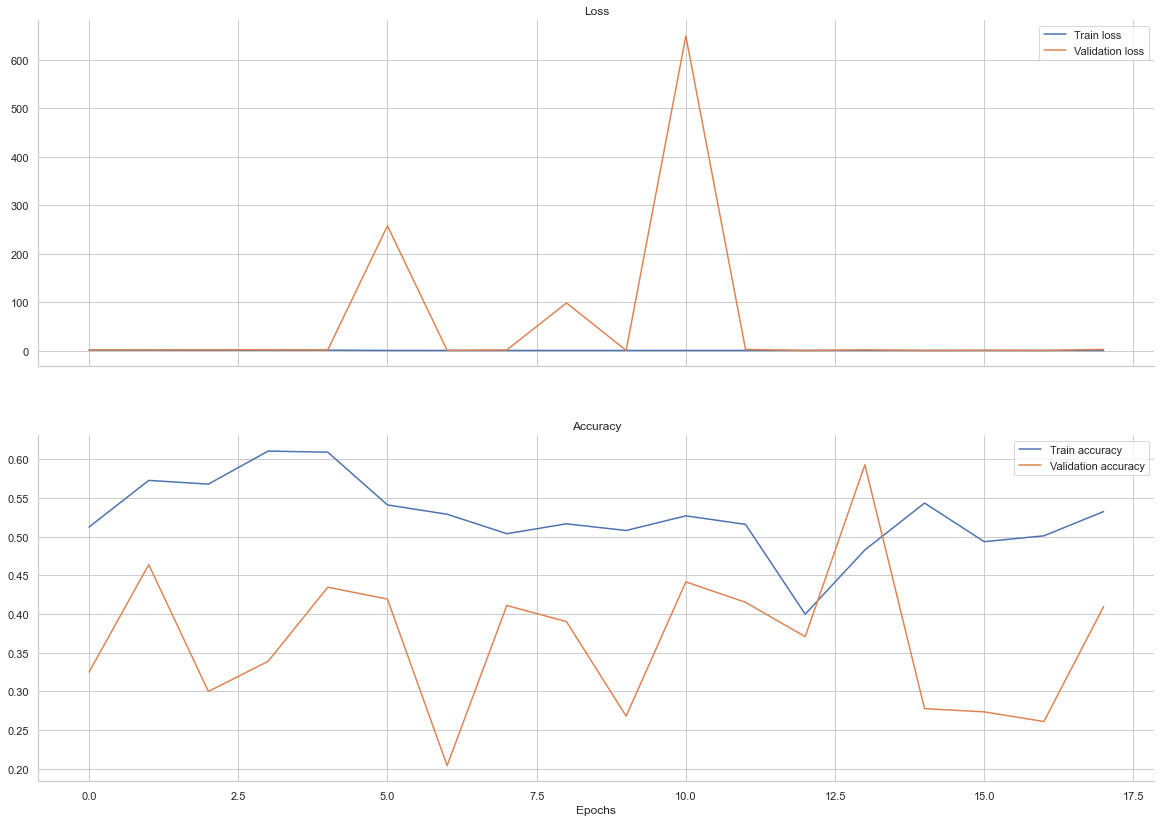

In [32]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation

## Confusion Matrix

In [33]:
# Create empty arays to keep the predictions and labels
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))
lastFullTestPred = np.empty((0, N_CLASSES))
lastFullTestLabels = np.empty((0, N_CLASSES))

# Add Val predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

# Add Test predictions and labels
for i in range(STEP_SIZE_TEST+1):
    im, lbl = next(test_generator)
    scores = model.predict(im, batch_size=test_generator.batch_size)
    lastFullTestPred = np.append(lastFullTestPred, scores, axis=0)
    lastFullTestLabels = np.append(lastFullTestLabels, lbl, axis=0)
    
  
lastFullComPred = np.concatenate((lastFullValPred, lastFullTestPred))
lastFullComLabels = np.concatenate((lastFullValLabels, lastFullTestLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

val_preds = [np.argmax(pred) for pred in lastFullValPred]
val_labels = [np.argmax(label) for label in lastFullValLabels]

test_preds = [np.argmax(pred) for pred in lastFullTestPred]
test_labels = [np.argmax(label) for label in lastFullTestLabels]

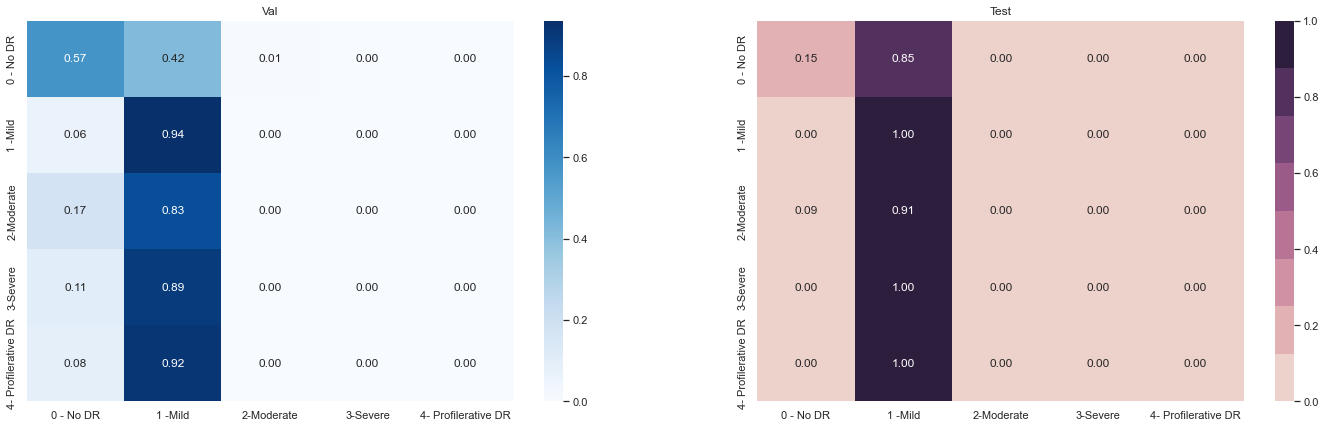

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 -Mild', '2-Moderate', '3-Severe', '4- Profilerative DR']
val_cnf_matrix = confusion_matrix(val_labels, val_preds)
test_cnf_matrix = confusion_matrix(test_labels, test_preds)

val_cnf_matrix_norm = val_cnf_matrix.astype('float') / val_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix.astype('float') / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

val_df_cm = pd.DataFrame(val_cnf_matrix_norm, index=labels, columns=labels)
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(val_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Val')
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Test')
plt.show()

In [35]:
labels = ['0 - No DR', '1 -Mild', '2-Moderate', '3-Severe', '4- Profilerative DR']
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_preds, target_names=labels))

                     precision    recall  f1-score   support

          0 - No DR       0.62      0.15      0.24        34
            1 -Mild       0.05      1.00      0.10         5
         2-Moderate       0.00      0.00      0.00        32
           3-Severe       0.00      0.00      0.00        19
4- Profilerative DR       0.00      0.00      0.00        14

           accuracy                           0.10       104
          macro avg       0.14      0.23      0.07       104
       weighted avg       0.21      0.10      0.08       104



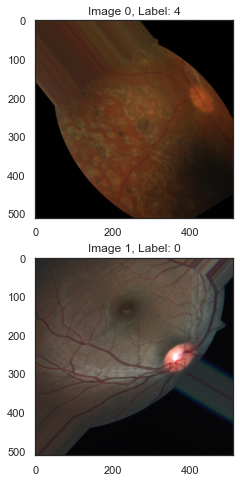

In [36]:
n_explain = 2
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

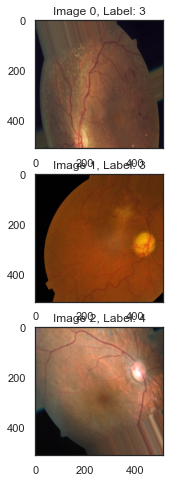

In [37]:
n_explain = 3
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)
flag=0
c=1

def select(background, lbls):
    flag=0
    for index, image in enumerate(background[:n_explain]):
        # print(np.argmax(lbls[index]))
        if((np.argmax(lbls[index]) == 3) or (np.argmax(lbls[index]) == 4)):
            flag = flag+1
    
    return background, lbls, flag

background, lbls, c = select(background, lbls)
while(c!=n_explain):
    background, lbls = next(valid_generator)
    background, lbls, c = select(background, lbls)
    

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
model

In [40]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [41]:
model.layers[0]

In [42]:
# Find the last convolutional layer in the ResNet50 model
last_conv_layer_name = ''
for layer in model.layers[:-1]:
    if 'conv' in layer.name:
        print(layer.name)
        last_conv_layer_name = layer.name


In [43]:
from lime import lime_image

In [44]:
from skimage.segmentation import mark_boundaries

In [45]:
def visualize(file_path,ax,text_loc):
    
    test_image = cv2.imread(file_path, cv2.IMREAD_COLOR)
    test_image = test_image/255
    test_image = cv2.resize(test_image, (256, 256))
    test_image = np.expand_dims(test_image,axis=0)
    probs = model.predict(test_image)
    pred_class = np.argmax(probs)
    #pred_class = class_dict[pred_class]

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(test_image[0], model.predict, top_labels=14, hide_color=0, num_samples=100)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + str(pred_class) , fontsize=13)
    #true_class = find_true_class(file_path)
    #if true_class is not None:
    #    fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


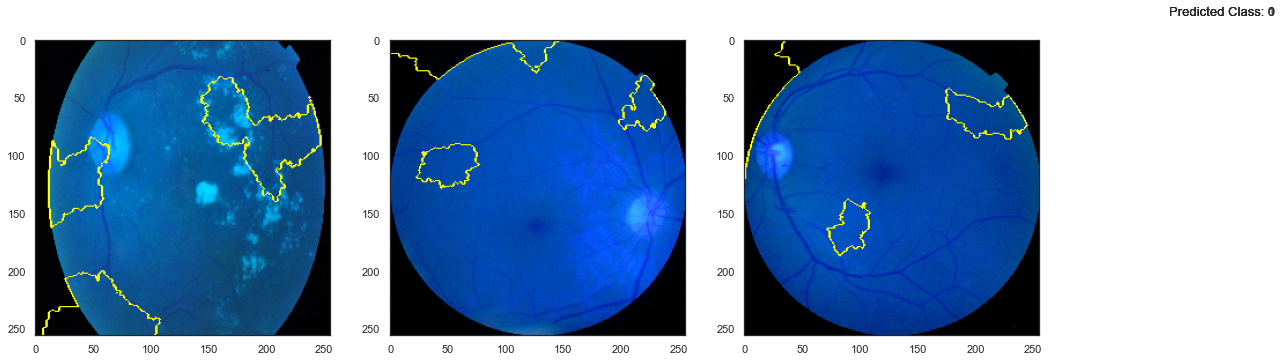

In [46]:
img_path1 = 'train_images/0104b032c141.png'
img_path2 = 'train_images/0a902c80d5da.png'
img_path3 = 'train_images/0afbeeef0ff7.png'
fig,ax = plt.subplots(1,3,figsize=(18,6))

visualize(img_path1, ax[0], 1)
visualize(img_path2, ax[1], 1)
visualize(img_path3, ax[2], 1)

In [47]:
model.output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'final_output')>

In [48]:
def grad_cam(my_image, model):
  DIM = 512

  #img = image.load_img(fname, target_size=(DIM, DIM))
  #x = image.img_to_array(img)/255.
  #x = np.expand_dims(x, axis=0)
  my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
  data=np.array(my_image)/255 # convert to an np array and rescale images

  preds = model.predict(data)
  pred_bool = (preds>0.5).astype(int).ravel()

  print(f"This image has label")
  print('')
  print(f'Diabetic retinopathy  {pred_bool}')

  #remodel= model.layers[0]
  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_44')
    iterate = tf.keras.models.Model([model.input], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(data)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(-3 -2, -1))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape(((my_image.shape[1], my_image.shape[0])))
  plt.matshow(heatmap)
  plt.show()

  img = data#cv2.imread(fname)

  INTENSITY = 0.5
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img1 = heatmap * INTENSITY + img

  plt.imshow(cv2.resize(img, (300, 300)))
  plt.imshow(cv2.resize(img1, (300, 300)))

In [49]:
# Activati
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Get the last convolutional layer of the model
last_conv_layer = model.get_layer('conv2d_44')

# Get the gradient of the output with respect to the last conv layer
grad_model = Model([model.inputs], [model.get_layer('conv2d_44').output, model.output])
with tf.GradientTape() as tape:
    conv_output, predictions = grad_model([my_image])
    loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_output)[0]
    
# Get the mean of the gradients over all channels
#pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each channel in the feature map array by the corresponding gradient
for i in range(grads.shape[-1]):
    conv_output[:, :, i] *= grads[i]

# Create heatmap
heatmap = np.mean(conv_output, axis=-1)

# Normalize heatmap
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

# Resize heatmap to the size of the input image
heatmap = cv2.resize(heatmap, (my_image.shape[1], my_image.shape[0]))

# Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on the input image
superimposed_img = cv2.addWeighted(my_image, 0.5, heatmap, 0.5, 0)

# Plot the original image, heatmap and superimposed image
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(my_image / 255)
axs[0].set_title('Original Image')
axs[1].imshow(heatmap)
axs[1].set_title('Heatmap')
axs[2].imshow(superimposed_img / 255)
axs[2].set_title('Superimposed Image')
plt.show()


ValueError: No such layer: conv2d_44.

In [ ]:
pooled_grads

In [ ]:
import keras
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
import numpy as np

def GradCAM(model):
    """Computes Grad-CAM visualizations for a given model."""
    # Compute the gradients of the last convolutional layer with respect to the input image.
    gradients = model.layers[-5].gradients_backprop(model.output, True)

    # Compute the weights of the last convolutional layer.
    weights = model.layers[-5].weights

    # Compute the Grad-CAM visualization.
    grad_cam_visualization = np.mean(gradients * weights, axis=2)

    return grad_cam_visualization

def LIME(model, image, label):
    """Generates LIME explanations for a given model and image."""
    # Generate a random explanation.
    explanation = np.random.rand(image.shape[0], image.shape[1])

    # Score the explanation with the model.
    model_score = model.predict(explanation)

    # Normalize the explanation.
    explanation /= np.max(explanation)

    return explanation, model_score

def visualize(model, image, label, grad_cam_visualization, explanation):
    """Visualizes Grad-CAM and LIME explanations for a given model, image, label."""
    # Plot the Grad-CAM visualization.
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].imshow(image)
    ax[0, 1].imshow(grad_cam_visualization, cmap='gray')

    ax[1, 0].imshow(explanation, cmap='gray')
    ax[1, 1].imshow(label, cmap='binary')

    plt.show()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
# Load the image and preprocess it
img_path = 'train_images/0104b032c141.png'
mage = load_img(img_path, target_size=(512, 512))

#mage = keras.image.load_image('train_images/0104b032c141.png')

# Generate the Grad-CAM visualization.
grad_cam_visualization = GradCAM(model)
label=2

# Generate the LIME explanation.
explanation, model_score = LIME(model, image, label)

### Now the SHAP explanation

In [ ]:
new_model.summary()

In [ ]:
print(tf.__version__)

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(new_model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

- The plot above explains five outputs (our five levels of diabetic retinopathy 0-5) for three different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left (they are black because most of the pixels are greater than 0), and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset, here I'm using 10 images) and the current model output. 
- Note that for the images that the label is "1.0" (the correct one), we a greater pink area.
- Labels that have as much pink area as the correct one are labels that our model probably doesn't have a high confidence prediction.

## Let's try on a few more images

In [ ]:
n_explain = 3
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[12, 12])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(new_model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

## Apply model to test set and output predictions

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

# Predictions class distribution

In [ ]:
fig = plt.subplots(1, 1, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [ ]:
results.to_csv('submission.csv', index=False)
results.head(10)

In [50]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [54]:

from keras.preprocessing.image import load_img, img_to_array
# Load the image and preprocess it
img_path = 'train_images/0104b032c141.png'
image = load_img(img_path, target_size=(512, 512))


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(image, model, 'final_output')

# Display heatmap
plt.matshow(heatmap)
plt.show()

TypeError: Inputs to a layer should be tensors. Got: <PIL.Image.Image image mode=RGB size=512x512 at 0x14881420D48>

In [53]:
model.layers